# Analisis exploratorio de los datos
Primero importamos librerias y datos a ser usados
Para juntar datos de varias columnas en una sola se ha usado la funcion get_values, obtenida del link: https://stackoverflow.com/questions/38334296/reversing-one-hot-encoding-in-pandas

In [326]:
#Importar librerias a usar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#CREACION DE FATA FRAMES
df_metadata = pd.read_csv("c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Metadata.csv")
df_data_type = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Data type.csv')
df_participants = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Participants.csv')
df_self_report = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Self report.csv')
df_emotion_elicitation_techniques = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - EDA.csv')
df_statistical_learning_models = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Statistical Learning model.csv')
df_performances = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Performances.csv')
df_alg_perf = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Alg_Perf.csv')



## 1. grafico de barra por año para modelos categoriales y dimensionales

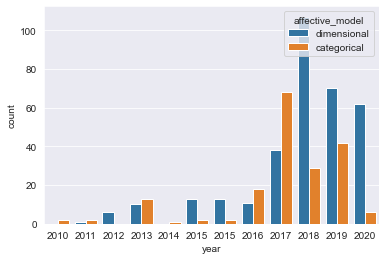

In [327]:
#rellenar datos faltantes y NO SE DROPEAN los duplicados (hay papers que usan multiples modelos)
df_statistical_learning_models=df_statistical_learning_models.fillna('-')

#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
sns.set_style('darkgrid')
sns.countplot(x='year', 
    data= df_statistical_learning_models, 
    hue='affective_model', 
    order=category_order)
plt.show()



## 2. Análisis estadístico para determinar si modelos de detección de arousal performan mejor que los basados en valence (Algoritmos de regresión)
- Procedimiento: subsetear para quedarnos con modelos dimensionales(columna affective model), subsetear con regressor, donde nos quedamos solo con las dimensiones que sean arousal/valence, quedarse con la medida de perforrmace que mas aparezca (count), hacer el test estadístico correspondiente (t, wettney, etc)
- Resultado: no existe diferencia estadisticamente significativa entre grupos, por lo que los algoritmos de regresión basados en modelos dimensionales (basados en arousal o valence) no performan mejor uno sobre otros (Segun t de student y u de mann-whitney).


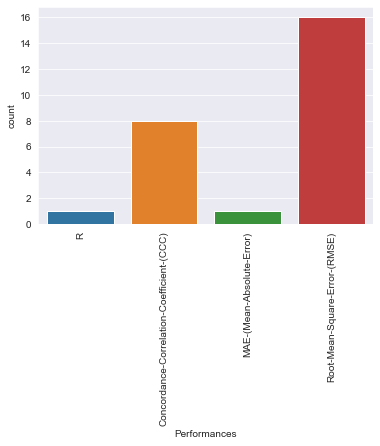

In [328]:

#unir data frames, y subseteo por: modelos dimensionales, tipo regressor, dimensiones arousal/valence
df = df_alg_perf
df = df[df['affective_model'] == 'dimensional']
df = df[df['is_regressor'].isin(['x', 'X'])]
df = df[df['regre_model_output_dimensions'].isin(['arousal', 'valence'])]

#que medida de performance mas aparece? - es RMSE
#dataframe con performances
df_performance_medidas = df.iloc[:,67:]

df_performance_medidas = df_performance_medidas.fillna('No')
df_performance_medidas = df_performance_medidas.replace('-', 'No')
df_performance_medidas=df_performance_medidas.mask(df_performance_medidas != 'No','Yes')

#obtener performance mas frecuente
def get_value(row):
    for c in df_performance_medidas.columns:
        if row[c] == 'Yes':
            return c

df_performance_medidas = df_performance_medidas.apply(get_value, axis=1)
df_performance_medidas = pd.DataFrame(df_performance_medidas)
df_performance_medidas.columns = ['Performances']

sns.countplot(x='Performances', data=df_performance_medidas)
plt.xticks(rotation=90)
plt.show()

#subseteo por la medida de performance que mas aparece
df = df.fillna('-')
df = df[df['Root-Mean-Square-Error-(RMSE)'] != '-']

#print(df)



Aplicamos los estadísticos

obtenido de: https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

In [329]:

df_arousal = df[df['regre_model_output_dimensions'] == 'arousal']
df_arousal = df_arousal['Root-Mean-Square-Error-(RMSE)']
arousal = df_arousal.values.tolist()
arousal = list(map(float, arousal))

df_valence = df[df['regre_model_output_dimensions'] == 'valence']
df_valence = df_valence['Root-Mean-Square-Error-(RMSE)']
valence = df_valence.values.tolist()
valence = list(map(float, valence))

#Test parametrico - t de student
print('Students t-test')
from scipy.stats import ttest_ind
stat, p = ttest_ind(arousal, valence)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


#Test no parametrico - U de Mann-Whitney
print('Mann-Whitney U Test')
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(arousal, valence)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


Students t-test
stat=0.679, p=0.508
Probably the same distribution
Mann-Whitney U Test
stat=44.500, p=0.207
Probably the same distribution


## 3. Análisis estadístico para determinar si modelos de detección de arousal performan mejor que los basados en valence (Algoritmos de clasificación)
- Procedimiento: subsetear para quedarnos con modelos dimensionales(columna affective model), quedarse solo con clasificación binarias (LA,HA/LV,HV), quedarse con la medida de performance que mas aparezca (hacer count). hacer el test estadístico correspondiente (t, wettney, etc), que depende del supuesto (si hay normalidad se aplica paramétrico, sino no-parametrico).
- Resultado: no existe diferencia estadisticamente significativa entre grupos, por lo que los algoritmos clasificadores basados en modelos dimensionales de clasificacion binaria (HA/LA, HV/LV) no performan mejor uno sobre otros (Segun t de student y u de mann-whitney).

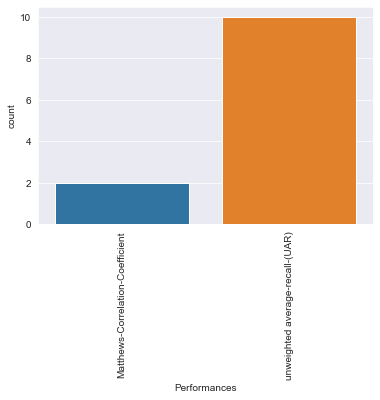

In [330]:
#unir data frames, y subseteo por: modelos dimensionales, tipo clasiffier, dimensiones arousal/valence
df_2 = df_alg_perf
df_2 = df_2[df_2['affective_model'] == 'dimensional']
df_2 = df_2[df_2['is_classifier'].isin(['x', 'X'])]
df_2 = df_2[df_2['class_model_output_categories'].isin(['HA, LA', 'HV, LV'])]

#que medida de performance mas aparece? - es accuracy
#dataframe con performances
df2_performance_medidas = df_2.iloc[:,67:]

df2_performance_medidas = df2_performance_medidas.fillna('No')
df2_performance_medidas = df2_performance_medidas.replace('-', 'No')
df2_performance_medidas=df2_performance_medidas.mask(df2_performance_medidas != 'No','Yes')

def get_value(row):
    for c in df2_performance_medidas.columns:
        if row[c] == 'Yes':
            return c

df2_performance_medidas = df2_performance_medidas.apply(get_value, axis=1)
df2_performance_medidas = pd.DataFrame(df2_performance_medidas)
df2_performance_medidas.columns = ['Performances']

sns.countplot(x='Performances', data=df2_performance_medidas)
plt.xticks(rotation=90)
plt.show()

#subseteo por la medida de performance que mas aparece
df_2 = df_2.fillna('-')
df_2 = df_2[df_2['unweighted average-recall-(UAR)'] != '-']

#744 rows = modelos que cumplen todos los requerimientos



In [331]:
df_arousal = df_2[df_2['class_model_output_categories'] == 'HA, LA']
df_arousal = df_arousal['unweighted average-recall-(UAR)']
arousal = df_arousal.values.tolist()
arousal = list(map(float, arousal))

df_valence = df_2[df_2['class_model_output_categories'] == 'HV, LV']
df_valence = df_valence['unweighted average-recall-(UAR)']
valence = df_valence.values.tolist()
valence = list(map(float, valence))

#Test parametrico - t de student
print('Students t-test')
from scipy.stats import ttest_ind
stat, p = ttest_ind(arousal, valence)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


#Test no parametrico - U de Mann-Whitney
print('Mann-Whitney U Test')
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(arousal, valence)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

Students t-test
stat=2.213, p=0.058
Probably the same distribution
Mann-Whitney U Test
stat=22.000, p=0.056
Probably the same distribution


## 4. frencuencia de los modelos algortimicos

Interpretaciones: Los algoritmos clasificadores son por mucho los mas usados, ademas de ser los que mas variedad representan. Que implica esto? Es lo mismo aplicar algoritmos clasificadores o regresores?

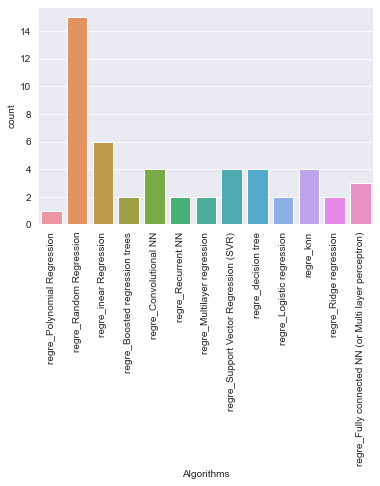

c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


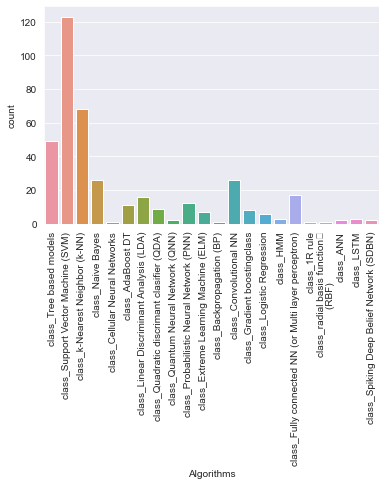

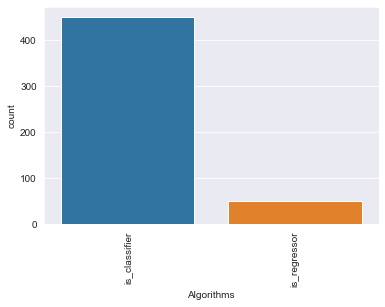

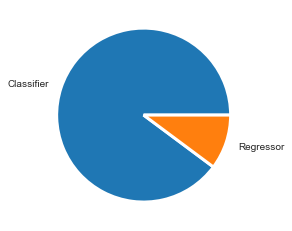

In [332]:
#para regressor
df_algoritmos_regre = df_statistical_learning_models.iloc[:,43:58]

def get_value(row):
     for c in df_algoritmos_regre.columns:
         if row[c]== 'x':
             return c

df_algoritmos_regre = df_algoritmos_regre.apply(get_value, axis=1)
df_algoritmos_regre = pd.DataFrame(df_algoritmos_regre)
df_algoritmos_regre.columns = ['Algorithms']

sns.countplot(x='Algorithms', data=df_algoritmos_regre)
plt.xticks(rotation=90)
plt.show()

#para classifier
df_algoritmos_class = df_statistical_learning_models.iloc[:,8:40]
def get_value(row):
     for c in df_algoritmos_class.columns:
         if row[c]== 'x':
             return c

df_algoritmos_class = df_algoritmos_class.apply(get_value, axis=1)
df_algoritmos_class = pd.DataFrame(df_algoritmos_class)
df_algoritmos_class.columns = ['Algorithms']

sns.countplot(x='Algorithms', data=df_algoritmos_class)
plt.xticks(rotation=90)
plt.show()

#is classifier o is regressor
df_class_or_regre = df_statistical_learning_models.iloc[:,[5,40]]
def get_value(row):
     for c in df_class_or_regre.columns:
         if row[c]== 'x':
             return c

df_class_or_regre = df_class_or_regre.apply(get_value, axis=1)
df_class_or_regre = pd.DataFrame(df_class_or_regre)
df_class_or_regre.columns = ['Algorithms']

sns.countplot(x='Algorithms', data=df_class_or_regre)
plt.xticks(rotation=90)
plt.show()

#pie plot
quantity = df_class_or_regre['Algorithms'].value_counts()
df_class_or_regre_quantity = pd.DataFrame(quantity)

names = 'Classifier', 'Regressor'
plt.pie(df_class_or_regre_quantity['Algorithms'], labels = names, labeldistance = 1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.show()


## 5. frencuencia de los tipos de elicitation (por modalidad o tecnica especifica)

Nota: Falta organizar bien la data en la tabla, para obtener las siguientes barras: multimodal, modalidad visual, mod auditory, mod somatosensory

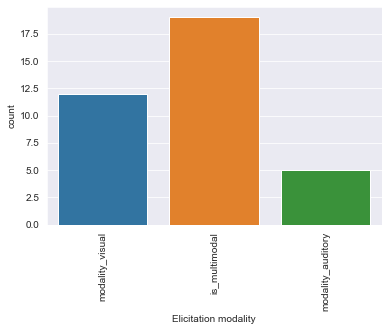

In [333]:
#frecuencia tipos elicitation por modalidad

df_emotion_elicitation_techniques=df_emotion_elicitation_techniques.fillna('-')
df_emotion_elicitation_techniques_sin_duplicates = df_emotion_elicitation_techniques.drop_duplicates(subset='paper_id')

df_eli_modalidad = df_emotion_elicitation_techniques_sin_duplicates.iloc[:,3:7]
def get_value(row):
     for c in df_eli_modalidad.columns:
         if row[c]== 'x':
             return c

df_eli_modalidad = df_eli_modalidad.apply(get_value, axis=1)
df_eli_modalidad = pd.DataFrame(df_eli_modalidad)
df_eli_modalidad.columns = ['Elicitation modality']

sns.countplot(x='Elicitation modality', data=df_eli_modalidad)
plt.xticks(rotation=90)
plt.show()

## 6. grafico de barra por año para tipos de base de datos

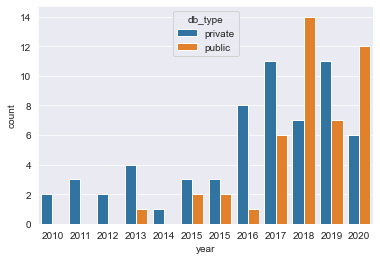

In [334]:
#rellenar datos faltantes y dropeo de duplicados
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
sns.set_style('darkgrid')
sns.countplot(x='year', 
    data= df_data_type_sin_duplicates, 
    hue='db_type', 
    order=category_order)
plt.show()

## 7. frencuencia por base de datos
Interpretacion: Un predominio de pocas bases de datos. Estamos todo el tiempo sacando conclusiones sobre los mismos sujetos? Ver predominio de bases de datos publicas por sobre las privadas

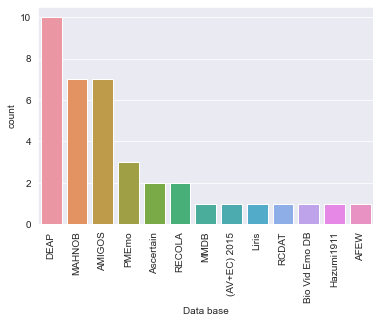

In [335]:
#bases de datos
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

df_db = df_data_type_sin_duplicates.iloc[:,10:]
def get_value(row):
     for c in df_db.columns:
         if row[c]== 'x':
             return c

df_db = df_db.apply(get_value, axis=1)
df_db = pd.DataFrame(df_db)

df_db = df_db.replace('Multimodal Dyadic Behavior (MMDB)', 'MMDB')
df_db.columns = ['Data base']

category_order = ['DEAP', 'MAHNOB', 'AMIGOS', 'PMEmo', 'Ascertain', 'RECOLA', 'MMDB', '(AV+EC) 2015', 'Liris','RCDAT','Bio Vid Emo DB','Hazumi1911','AFEW']
sns.countplot(x='Data base', data=df_db, order = category_order)
plt.xticks(rotation=90)
plt.show()

## 8. frecuencia journal, por si es ingeniería o no

Nota: falta filtrar bien cuales son journal, y cuales de estas son de ingenieria o no (diferenciarlas con color o hue)

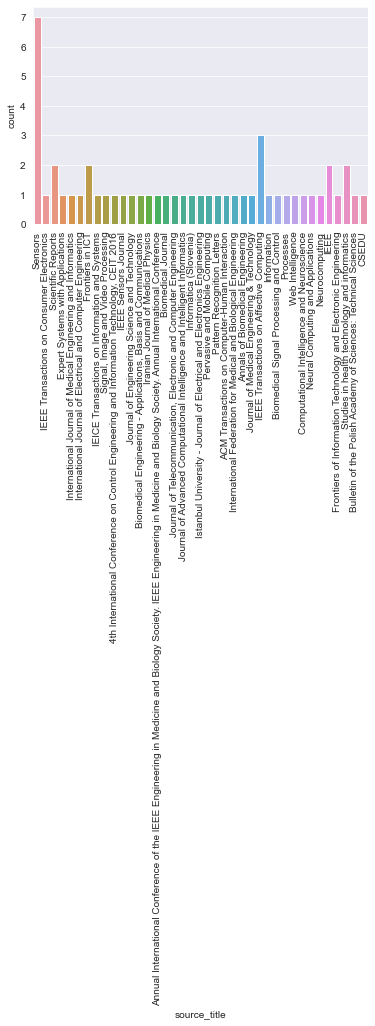

In [336]:
#por revista
df_metadata=df_metadata.fillna('-')
df_metadata_sin_duplicates = df_metadata.drop_duplicates(subset='paper_id')

df_source_title = df_metadata_sin_duplicates[['paper_id','source_title','source_type_journal']]

df_source_title = df_source_title[df_source_title['source_type_journal'].isin(['x', 'X'])]

sns.countplot(x='source_title', data=df_source_title)
plt.xticks(rotation=90)
plt.show()

## 9. Analisis extras